# Hands-on 3: Kmeans Notebook (Tutorial)


**Alumno:** _Herrera Covarrubias Kevin Shalom_  
**Curso / Profesor:** _Clasificacion Inteligente de Datos / Jose Antonio Aviña Mendez_



## Fundamentos de la técnica

**K-Means** agrupa datos en **K clústeres** minimizando la suma de distancias cuadráticas a los **centroides**. Itera entre **asignar** cada punto al centroide más cercano y **actualizar** centroides como promedios.


## Modelo Matemático

Sea $X=\{x_1,\dots,x_n\}\subset\mathbb{R}^d$ y un número de clústeres $K$.  
El objetivo de **K-Means** es encontrar una partición $\{C_1,\dots,C_K\}$ y centroides $\{\mu_1,\dots,\mu_K\}$ que **minimicen** la **suma intra–clúster de cuadrados** (*Within-Cluster Sum of Squares*, WCSS):

$$
\min_{\{C_i\},\{\mu_i\}} \; J = \sum_{i=1}^{K} \sum_{x_j \in C_i} \| x_j - \mu_i \|^2
$$

**Forma con variables de asignación.**  
Definimos $z_{ij}\in\{0,1\}$ tal que $z_{ij}=1$ si $x_j$ pertenece al clúster $i$ y $0$ en otro caso, con la restricción $\sum_{i=1}^K z_{ij}=1$ para todo $j$:

$$
\min_{\mathbf{Z},\{\mu_i\}} \; J(\mathbf{Z},\mu) =
\sum_{j=1}^{n}\sum_{i=1}^{K} z_{ij}\,\| x_j - \mu_i \|^2
\quad \text{sujeto a } z_{ij}\in\{0,1\},\; \sum_{i=1}^K z_{ij}=1.
$$

**Óptimo en $\mu_i$ (con $Z$ fijo).**  
Cada centroide es el **promedio** de su clúster:

$$
\mu_i^* = \frac{\sum_{j=1}^n z_{ij}\,x_j}{\sum_{j=1}^n z_{ij}}.
$$

**Algoritmo de Lloyd (iterativo):**

1. **Asignación:** $z_{ij}=1 \iff i=\arg\min_k \|x_j-\mu_k\|^2$
2. **Actualización:** $\mu_i \leftarrow \frac{1}{|C_i|}\sum_{x_j\in C_i} x_j$
3. Repetir hasta **convergencia** (descenso de $J$ o centroides estables).



## 1.3 Librerías / clases / funciones

Usamos StandardScaler para escalar los datos porque K-Means usa distancias euclidianas, y si una variable tiene números grandes, domina sobre las demás.
Después usamos KMeans de sklearn.cluster, que nos permite definir:

n_clusters: número de grupos (en este caso 2).

init='k-means++': inicialización inteligente para evitar malos comienzos.

random_state=42: para reproducir el resultado.
Finalmente, usamos un Pipeline para conectar ambos pasos en un solo flujo: escalado + clustering.


## Pipeline

### a) Preprocesamiento

Shape: (400, 5)
    User ID  Gender  Age  EstimatedSalary  Purchased
0  15624510    Male   19            19000          0
1  15810944    Male   35            20000          0
2  15668575  Female   26            43000          0
3  15603246  Female   27            57000          0
4  15804002    Male   19            76000          0

Estadística básica (mean, std, min, max):
                       mean           std      min       max
Age                 37.655     10.482877     18.0      60.0
EstimatedSalary  69742.500  34096.960282  15000.0  150000.0


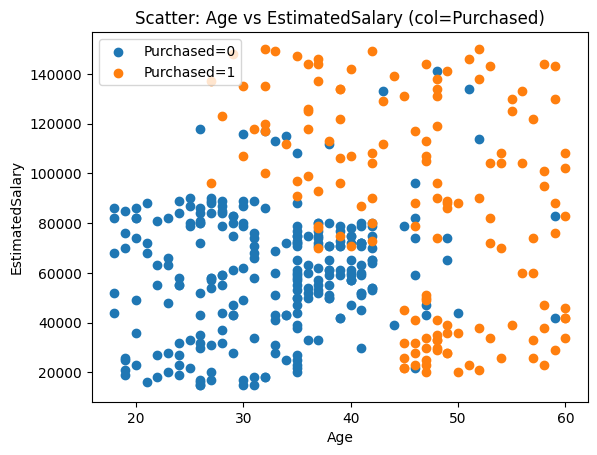

In [5]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
DATA_PATH = Path('/content/Social_Network_Ads.csv')
df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
print(df.head())
stats = df[['Age','EstimatedSalary']].describe().T[['mean','std','min','max']]
print('\nEstadística básica (mean, std, min, max):\n', stats)

plt.figure()
for label, subset in df.groupby('Purchased'):
    plt.scatter(subset['Age'], subset['EstimatedSalary'], label=f'Purchased={label}')
plt.xlabel('Age'); plt.ylabel('EstimatedSalary'); plt.title('Scatter: Age vs EstimatedSalary (col=Purchased)')
plt.legend(); plt.show()


### Explicación
- Primero observamos el dataset Social Network Ads.
Solo usamos dos columnas: Age y EstimatedSalary, porque son numéricas y fáciles de graficar.
Calculamos estadísticas básicas (media, desviación, etc.) y hacemos un gráfico scatter para ver si hay grupos visuales.
Eso nos da una idea de cómo se podrían formar los clústeres.

### b) Entrenamiento de K-Means

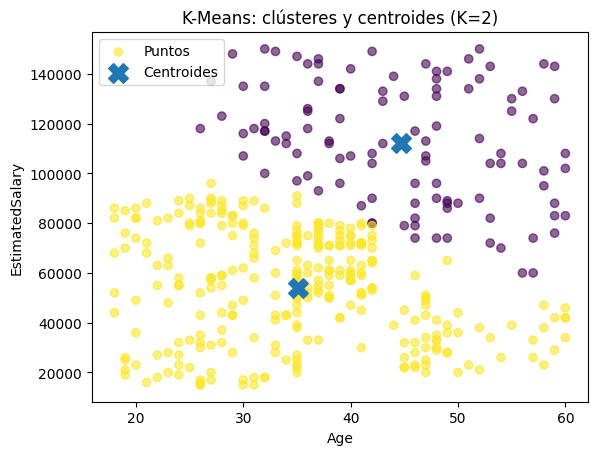

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

X = df[['Age','EstimatedSalary']].values

kmeans_pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=2, n_init=10, random_state=42))
])
kmeans_pipe.fit(X)
cluster_labels = kmeans_pipe.named_steps['kmeans'].labels_

# Centroides a escala original
centroids_std = kmeans_pipe.named_steps['kmeans'].cluster_centers_
scaler = kmeans_pipe.named_steps['scaler']
centroids_orig = scaler.inverse_transform(centroids_std)

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(X[:,0], X[:,1], c=cluster_labels, alpha=0.6, label='Puntos')
plt.scatter(centroids_orig[:,0], centroids_orig[:,1], marker='X', s=200, label='Centroides')
plt.xlabel('Age'); plt.ylabel('EstimatedSalary'); plt.title('K-Means: clústeres y centroides (K=2)')
plt.legend(); plt.show()


### Explicación
- Luego entrenamos el modelo K-Means con n_clusters=2.
Esto significa que queremos dividir los datos en dos grupos.
El algoritmo automáticamente busca los dos centroides que minimizan las distancias de los puntos a ellos.
En el gráfico, vemos los puntos coloreados por grupo y los centroides marcados con una X.

### c) Prediction (función)

In [7]:
def predecir_cluster(modelo, age, est_salary):
    import numpy as np
    v = np.array([[age, est_salary]])
    return int(modelo.predict(v)[0])

print('Ejemplo de clúster predicho:', predecir_cluster(kmeans_pipe, X[0,0], X[0,1]))


Ejemplo de clúster predicho: 1


### Explicación
- Creamos una pequeña función que recibe Age y EstimatedSalary y devuelve a qué grupo pertenece ese nuevo punto.
Es útil para probar manualmente el modelo con nuevos datos y ver en qué grupo caería una persona hipotética.

### d) Model Evaluation (Matriz de Confusión + Accuracy, usando `Purchased` como referencia)

Mapeamos cada clúster a la clase (`0/1`) por **mayoría** para comparar contra `Purchased`.

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
y_true = df['Purchased'].values
y_clusters = cluster_labels.copy()

mapping = {}
for cl in np.unique(y_clusters):
    mask = (y_clusters == cl)
    majority = int(np.bincount(y_true[mask]).argmax())
    mapping[cl] = majority

y_pred_mapped = np.array([mapping[c] for c in y_clusters])
cm = confusion_matrix(y_true, y_pred_mapped)
acc = accuracy_score(y_true, y_pred_mapped)
print('Mapping clúster->clase:', mapping)
print('Matriz de Confusión:\n', cm)
print(f'\nAccuracy (mapeado): {acc:.4f}')


Mapping clúster->clase: {np.int32(0): 1, np.int32(1): 0}
Matriz de Confusión:
 [[239  18]
 [ 53  90]]

Accuracy (mapeado): 0.8225


### Explicación
- Aunque K-Means no es un modelo de clasificación, comparamos sus grupos con la columna Purchased (compró o no compró) para ver si los clústeres coinciden con el comportamiento real.
Para eso hacemos un mapeo de mayoría, donde vemos qué clase predomina en cada grupo.
Así generamos una matriz de confusión y un accuracy aproximado.

- Si el accuracy es alto, significa que los grupos que K-Means encontró se parecen bastante a los compradores y no compradores.
Si es bajo, quiere decir que las diferencias entre grupos no coinciden con las etiquetas reales.

### Conclusión de los resultados

“Con K-Means, logramos agrupar automáticamente a las personas del dataset sin usar la columna de compras.
Los grupos se forman por similitud de edad e ingresos, y en muchos casos coinciden con quién compró y quién no.

En resumen:

K-Means descubre patrones sin necesidad de etiquetas.

Funciona bien con datos numéricos y visualmente separables.

Pero no garantiza una clasificación exacta porque no tiene información supervisada.

En este caso, podemos decir que K-Means aprendió por sí mismo una estructura que se parece al comportamiento real de compra.”

## 3. Referencias bibliográficas

- scikit-learn — **KMeans**: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- scikit-learn — **Clustering**: https://scikit-learn.org/stable/modules/clustering.html
- Na, & Na. (2020, 15 julio). K-Means con Python paso a paso | Aprende Machine Learning. Aprende Machine Learning. https://www.aprendemachinelearning.com/k-means-en-python-paso-a-paso
- Cómo programar el algoritmo Kmeans en Python - Ander Fernández. (s. f.). Ander Fernández Jauregui - Machine Learning & Software Development. https://anderfernandez.com/blog/programar-kmeans-python